# Session 5: Deep Deep Q-learning to Drive MountainCar

## Setups

In [1]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls

# #gym
# !pip install gym #For full installations, see https://github.com/openai/gym#installation

# #displays
# !pip install pyvirtualdisplay
# !sudo apt-get install xvfb

# #torch and numpy
# !pip install numpy torchvision_nightly
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# import torch
# torch.__version__

## Imports

In [1]:
%matplotlib inline

#environments
import gym


#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#use cuda 0 if available; assuming 1 gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#misc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from collections import Counter, deque

#solutions
from solutions.agents import TaxiAgent

#shut up warnings
import warnings
warnings.filterwarnings("ignore")

MODEL_PATH = 'models/'

## Animation Imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

## Recap: What is Q-learning?

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma max_{a}Q(s_{t+1},a) - Q(s_t,a_t))$

where $max_{a}Q(s_{t+1},a)$ is the highest action value given state $s_{t+1}$. 

<img src="img/qlearning.png" alt="Q-learning"/>

where the green line denotes when we infer an action from the Q dictionary whereas the red lines denote when we udpate the Q dictionary.

**Concept Assignment** Run the Q-learning algorithm implemented in the `solutions` and answer the following questions:

1. What do the hyperparameters - gamma, alpha, and epsilon - mean?
2. Look inside the Q dictionary and explain how the agent choose an action based on this.

In [ ]:
#setups
env = gym.make('Taxi-v2')
a = TaxiAgent(env, gamma = 0.8, alpha = 1e-1,
                 start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999)

In [ ]:
#train
scores = []
moving_scores = []

moving_nb = 100
solved_score = 5
start_time = datetime.now()

for i in trange(10000):
    #for the record
    score = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.sarsa_update(state, action, reward, next_state, i)
        
        #records
        score+=reward
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

In [ ]:
plt.plot(moving_scores[:5000])
print(f'100-episode average score: {moving_scores[-1]}')

In [ ]:
'''
Write Your Code Here
'''

## [MountainCar-v0](https://gym.openai.com/envs/MountainCar-v0/)

`MountainCar-v0` envrionment is described at OpenAI Gym as:

`A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.`

In [ ]:
env = gym.make('MountainCar-v0')
state = env.reset()
score = 0
t=0
frames = []
while True:
    action = np.random.choice([0,1,2])
    state, reward, done, info = env.step(action)
    t+=1
    score+=reward
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
    if done: break
print(f'Done in {t} timsteps with score {score}.')

In [ ]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())

**Coding Assignment** Before we dive in, let us do some warm-up exercises of finding out more about `MountainCar-v0`

* State space
* Action space
* Rewards - It does not get anything for finishing the game but what about during the game?
* How many episodes does it take for the game to end

Hint: You can always look at its [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

In [ ]:
#create environment
env = gym.make('MountainCar-v0')
env.reset()

'''
Write your code here
'''


## Deep Q-Learning (DQN)

Deep Q-learning works almost the same as its "shallow" counterpart.

For every timestep:

1. We initialize the agent with two random Q networks: **local network** and **target network**.

2. The agent takes an epislon-greedy action based on given state.

3. We explicitly stores `(state, action, reward, next state)` tuples in a **replay memory** to be sampled and trained by the agent. We usually store the last arbitrary number of episodes to get memories "fresh" enough to be relevant but "old" enough for the training to be stable.

4. Every few timesteps, we update the **local network** using randomly chosen tuples from replay memory. This is done by calculating the loss with respect to the baseline which is the output of **target network**

5. Once in a while we copy the weights of the **local network** onto the **target network** in order to update the baseline.

<img src="img/dqn.png" alt="DQN"/>

where the green lines denote the process of infering an action (either "best" or random) and red lines denote the process of updating the Q network.

Therefore, we need the following components:
1. **Q Networks** - two neural networks that takes an input of state and output action values
2. **Agent** - a class that wraps around Q network performs two main functions: choose an action using epsilon greedy policy and update (train) Q network
3. **Replay Memory** - a data sampler than sample `(state, action, reward, next state)` tuples for training

## Train Your Own DQN Agent

Now that you understand the intuition behind how DQN works, let try training a model to solve `MountainCar-v0`. We will use an easy solve score of -150 as opposed to the official -110. Your goal is to adjust the hyperparameters to reach -150 over 100 episodes as soon as possible.

### Tune Hyperparameters

Some hyperparameters are more impactful than others. The only way to know how much each should be is to understand the intuition behind them and experiment with your assumptions. For instance, in this case, the ones you should look out for include but not limited to:

1. `lr` - The higher the learning rate, the faster your agent can learn but be careful not to set it too high otherwise your agent might be 'changing its mind' too fast and end up not learning anything. If your scores oscillate between some low numbers, it is a sign of too high a learning rate.

2. `nb_hidden` - As you can see in `solutions/networks.py`, the Q networks are simply two layers of linear and ReLU. The larger the number of hidden units for each layer, the more abstraction it can handle but it might take you longer to train as well.

3. `tau` - This is basically how fast you want to update your target network. For instance, `tau` of 0.3 means that for each time step, the weights of your target network will be $0.3 * W_{local} + 0.7 * W_{target}$.

4. `capacity` - This is not the agent's hyperparameter but rather its replay memory. The larger this is usually the better performance since the agent can sample more diverse transitions but that comes also with speed of training.

5. `update_interval` and `update_times` - The agent will update the local network every `update_interval` for `update_times` times. Updating your network too often can lead to unstable learning; updating too intermittenly will lead to slow speed of training.

In [3]:
from solutions.memory import VanillaMemory
from solutions.agents import DQNAgent

env = gym.make('MountainCar-v0')
mem = VanillaMemory(capacity=int(1e3)) #always store `capacity` timesteps
a = DQNAgent(state_size = 2, action_size = 3, replay_memory = mem, seed = 1412,
        lr = 1e-3, #learning rate; try something between 1e-4 and 1e-3
        bs = 256, #batch size; try 64, 128, 256
        clip = 1., #gradient clipping
        nb_hidden = 64, #number of hidden units in the q network; try 64,128,256,512
        gamma = 0.99, #discount factor
        tau= 1e-3, #how fast we update the target network; try something between 1e-2 and 1e-3
        update_interval = 5,  #how often we update local network
        update_times = 1, #how many times you train the local network per update
        tpe = 200) #how many timesteps per episode

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


You might think there is not much to do during training once all hyperparameters are fixed, but remember that we can also **engineer the reward** of our agent. Here we pass `fake_reward` to the agent for its step. Currently, the fake reward is equal to the real reward. Think of some ways to engineer the reward so that the agent gets even more motivated in finishing the task.

In [4]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()

for i in trange():
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    while True:
        t+=1
        #select action
        action = a.act(state)  

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motive your agent even more
        fake_reward = reward

        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
        
    #solved at -110; easy solve at -150
    if moving_scores[-1] > -150: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


It is also very useful to look at diagnostics of the models as you train:

* **Scores and average scores** - Your most important indicators. If they are stagnating, you should try tuning your hyperparameters because definitely there is something wrong.
* **Loss of local network** - Counterintuitively to when you train supervised models, a stable loss usually means a bad thing for a DQN agent. This is usually because the agent is either learning too slowly or not learning at all.

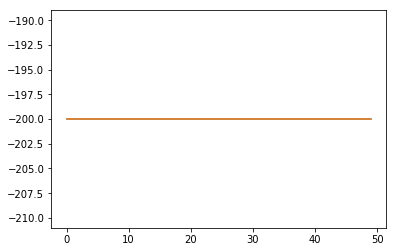

In [5]:
plt.plot(scores)
plt.plot(moving_scores)

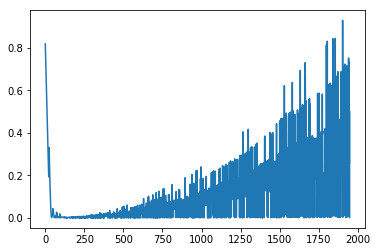

In [6]:
plt.plot(a.losses)

Test Your agent with the code below once you're done.

In [7]:
#somehow you need to do the animation import it again otherwise it wouldn't work
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [8]:
env = gym.make('MountainCar-v0')
state = env.reset()
score = 0
t=0
frames = []
for i in trange(200):
    #only infer action; no training
    action = a.act(state)
    
    #env step
    state, reward, done, info = env.step(action)
    
    #book keeping
    t+=1
    score+=reward
    
    #break if done
    if done: break
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
print(f'Done in {t} timsteps with score {score}.')

  0%|          | 0/200 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 96%|█████████▋| 193/200 [00:03<00:00, 58.63it/s]

Done in 200 timsteps with score -200.0.


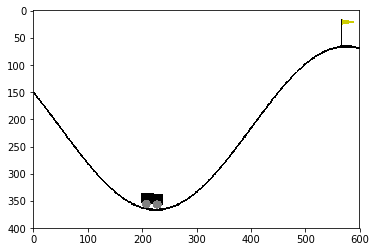

In [9]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())

## Inside DQN Agent

We now look inside how each part of DQN works.

### Replay Memory

Replay memory is a simple data class with only two methods: 
* `add` - add a tuple of `(state, action, reward, next_state,done)` to the memory
* `sample` - randomly sample a batch of `(state, action, reward, next_state,done)` for the agent to use for training.

**Coding Exercise** Refer to `solutions/memory.py` for source code of `VanillaMemory`.
* Add a tuple of `(state, action, reward, next_state,done)` from the environment (you can play with random actions or your agent from before) until the newly created replay memory `mem` is full. You can see the number of items by calling `len(mem)`.
* Sample a batch of 64 transitions. See what shapes are they in.

In [ ]:
env = gym.make('MountainCar-v0')
mem = VanillaMemory(capacity=int(1e3)) #always store `capacity` timesteps

'''
Write your code here
'''

### Q Networks

The Q networks are simply a neural network that takes input of state and output an action value for each action, as you can see in `solutions/networks.py`. A DQN agent has two networks:

* **Local network** used to select action
* **Target network** used as baseline to calculate the loss to train the local network

The local network gets trained every a few timesteps using backpropagation. The target network DOES NOT get trained with backpropagation but just copy the weights of the local network as time goes on.

In [23]:
a.network_local

QNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [24]:
a.network_target

QNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

### Agent Action Selection

The agent select an action EXACTLY the same way as they do in Q-learning.

**Concept Assignment** How do you think the agent select an action? How does it take into account exploration? See the `act` and `get_eps` methods of class `DQNAgent` in `solutions/agent.py` for some hints.

In [29]:
a.network_local(torch.tensor(env.reset(), dtype=torch.float))

tensor([-65.7832, -65.6372, -65.1643], grad_fn=<AddBackward0>)

### Agent Update

The update equation for DQN is as follows:

$$Q_{target} = R_{t+1} + \gamma\underset{a}{\operatorname{max}}Q_{target}(S_{t+1},a)$$
$$Q_{expected} = Q_{local}(S_{t},a)$$
$$L_{DQN} = E\biggl[\biggl(Q_{target} - Q_{expected}\biggl)^2\biggl] = MSELoss(Q_{target},Q_{expected})$$

Another more efficient variation of this update equation is called **Double Deep Q Learning (DDQN)** which only makes change to $Q_{target}$ as follows:

$$Q_{target} = R_{t+1} + \gamma Q_{target}(S_{t+1},\underset{a}{\operatorname{argmax}}Q_{local}(S_{t+1},a))$$

When calculating the target Q value, instead of just taking the maximum value, it takes the value that corresponds the best action of the local network instead. Doing this is reported by [its original paper](https://arxiv.org/pdf/1509.06461.pdf) to avoid overestimation of the action values.

In [ ]:
def learn(self, transitions, small_e = 1e-5):
    #vanilla
    states, actions, rewards, next_states, dones = transitions

    #vanilla
    q_targets_next = self.network_target(next_states).detach().max(1)[0].unsqueeze(1)
    #double
    max_actions_next = self.network_local(next_states).detach().max(1)[1].unsqueeze(1)
    q_targets_next = self.network_target(next_states).detach().gather(1, max_actions_next.long())

    #compute loss
    q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
    q_expected = self.network_local(states).gather(1, actions.long())
    #vanilla
    loss = self.vanilla_loss(q_expected, q_targets)
    #append for reporting
    self.losses.append(loss)

    #backprop
    self.optimizer.zero_grad()
    loss.backward()
    if self.clip: torch.nn.utils.clip_grad_norm(self.network_local.parameters(), self.clip)
    self.optimizer.step()

## Challenges

* Finetune the model and try to beat [OpenAI Leaderboard](https://github.com/openai/gym/wiki/Leaderboard) at 341 episodes. Use what you learn from this session such as creative reward engineering and other hyperparameter tunings.
* Try to figure out how you can solve `MountainCarContinuous-v0`. It is almost exactly the same as `MountainCar-v0` but with continuous action space of size 1. See [NAF Q-learning](https://arxiv.org/abs/1603.00748) and [DDPG](https://arxiv.org/abs/1509.02971) papers for some hints.

## Solution

### Model Setups

In [11]:
from solutions.memory import VanillaMemory
from solutions.agents import DQNAgent

env = gym.make('MountainCar-v0')
mem = VanillaMemory(capacity=int(1e5)) #always store `capacity` timesteps
a = DQNAgent(state_size = 2, action_size = 3, replay_memory = mem, seed = 1412,
        lr = 1e-3, #learning rate
        bs = 64, #batch size 
        clip = 1., #gradient clipping
        nb_hidden = 256, #number of hidden units in the q network
        gamma = 0.99, #discount factor
        tau= 0.05, #how much we copy from local network to target network at a time
        update_interval = 5,  #how often we update local network
        update_times = 1,
        tpe = 200) #how many timesteps per episode

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Training

In [12]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()

for i in trange(2000):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    while True:
        t+=1
        #select action
        action = a.act(state)  

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #extra reward
        if done: 
            fake_reward = reward + (200-t)/10
        else:
            fake_reward = reward

        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
        
    #solved at -110
    if moving_scores[-1] > -110: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

  5%|▍         | 99/2000 [00:32<10:20,  3.07it/s]

Episdoe 99 Moving Average: -194.67676767676767


 10%|▉         | 199/2000 [00:58<08:50,  3.40it/s]

Episdoe 199 Moving Average: -153.56


 15%|█▍        | 299/2000 [01:23<07:53,  3.59it/s]

Episdoe 299 Moving Average: -134.03


 20%|█▉        | 399/2000 [01:47<07:11,  3.71it/s]

Episdoe 399 Moving Average: -135.35


 25%|██▌       | 500/2000 [02:13<06:40,  3.75it/s]

Episdoe 499 Moving Average: -133.2


 30%|███       | 600/2000 [02:40<06:14,  3.74it/s]

Episdoe 599 Moving Average: -130.68


 35%|███▌      | 700/2000 [03:03<05:39,  3.82it/s]

Episdoe 699 Moving Average: -118.54


 40%|████      | 800/2000 [03:26<05:09,  3.88it/s]

Episdoe 799 Moving Average: -115.6


 45%|████▍     | 899/2000 [03:49<04:40,  3.92it/s]

Episdoe 899 Moving Average: -125.15


 50%|█████     | 1000/2000 [04:13<04:13,  3.94it/s]

Episdoe 999 Moving Average: -123.87


 55%|█████▍    | 1099/2000 [04:36<03:47,  3.97it/s]

Episdoe 1099 Moving Average: -118.06


 60%|█████▉    | 1199/2000 [05:02<03:22,  3.96it/s]

Episdoe 1199 Moving Average: -114.19


 61%|██████    | 1217/2000 [05:07<03:17,  3.96it/s]

Solved at Play 1217: 0:05:07.781686 Moving average: -109.7


### Diagnostics

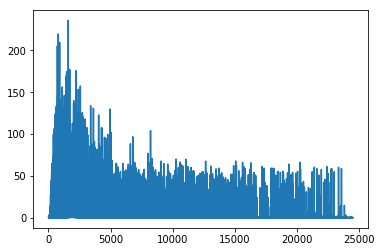

In [6]:
plt.plot(a.losses)

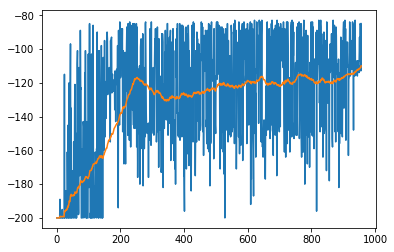

In [7]:
plt.plot(scores)
plt.plot(moving_scores)

### Save Model

In [19]:
#save network of solved agent
# torch.save(a.network_local.state_dict(),f'models/dqn.pth')

#load saved model
a = DQNAgent(state_size = 2, action_size = 3)
a.network_local.load_state_dict(torch.load(f'models/dqn.pth'))
a.t_step = 1e10

### Test Model

In [20]:
#somehow you need to do the animation import it again otherwise it wouldn't work
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [21]:
env = gym.make('MountainCar-v0')
state = env.reset()
score = 0
t=0
frames = []
for i in trange(200):
    #only infer action; no training
    action = a.act(state)
    
    #env step
    state, reward, done, info = env.step(action)
    
    #book keeping
    t+=1
    score+=reward
    
    #break if done
    if done: break
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
print(f'Done in {t} timsteps with score {score}.')

  0%|          | 1/200 [00:00<00:24,  8.15it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 53%|█████▎    | 106/200 [00:00<00:00, 166.50it/s]

Done in 107 timsteps with score -107.0.


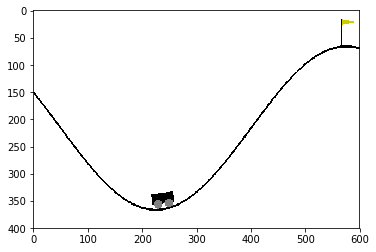

In [22]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())